Steps performed in this task:

    Load the MNIST dataset and prepare the data for training and testing.
    Define and train a deep network model on the MNIST dataset.
    Implement three different types of targeted attacks on five different numbers.
    Evaluate the performance of the attacks visually and quantitatively.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Step 1: Load and Prepare the MNIST Dataset

In [2]:
# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Define the classes
classes = [str(i) for i in range(10)]

100%|██████████| 9912422/9912422 [00:00<00:00, 278316215.66it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 7668272.07it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 67944073.92it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5148791.56it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Step 2: Define and Train the Deep Network Model

In [3]:
# Define the deep network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model and move it to the device
model = Net().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {running_loss / len(trainloader)}")

Epoch 1 loss: 0.3032726763562957
Epoch 2 loss: 0.13928334081251578
Epoch 3 loss: 0.10300218654341742
Epoch 4 loss: 0.08056582485425916
Epoch 5 loss: 0.0714580188463154
Epoch 6 loss: 0.0600089622435715
Epoch 7 loss: 0.05350371093071227
Epoch 8 loss: 0.04603994720859819
Epoch 9 loss: 0.042201127939425515
Epoch 10 loss: 0.039918201464935264


Step 3: Implement Targeted Attacks
Three types of targeted attacks are implemented below: Additive Noise, Random Pixel Manipulation, and Blurring. Random Pixel Manipulation is used as indistinguishable attack.

Additive Noise Attack:

In [4]:
def additive_noise_attack(image, epsilon):
    noise = torch.randn_like(image) * epsilon
    perturbed_image = image + noise
    return perturbed_image

Random Pixel Manipulation Attack:

In [13]:
def random_pixel_manipulation_attack(image, epsilon):
    perturbed_image = image.clone()
    pixels_to_manipulate = torch.rand(image.size()) < epsilon
    perturbed_image[pixels_to_manipulate.bool()] = torch.rand_like(perturbed_image[pixels_to_manipulate])
    return perturbed_image

Blurring Attack:

In [6]:
def blurring_attack(image, kernel_size, sigma):
    blurred_image = transforms.functional.gaussian_blur(image, kernel_size, sigma)
    return blurred_image

Step 4: Evaluate the Performance of the Attacks

In [15]:
# Set the model to evaluation mode
model.eval()

# Function to calculate the success rate
def calculate_success_rate(predictions, labels):
    return (predictions == labels).sum().item()

# Function to calculate the distance between two images
def calculate_distance(image1, image2):
    return torch.norm(image1 - image2)

Image 1:
Distance to original: 4.1100311279296875
Success rate: 1
-------------------------------------


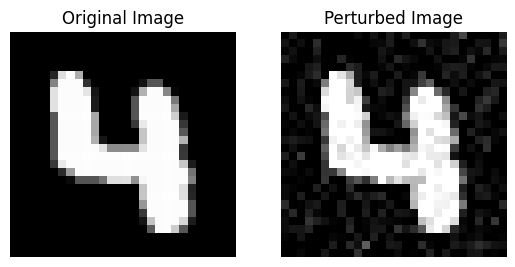

Image 2:
Distance to original: 4.069759368896484
Success rate: 1
-------------------------------------


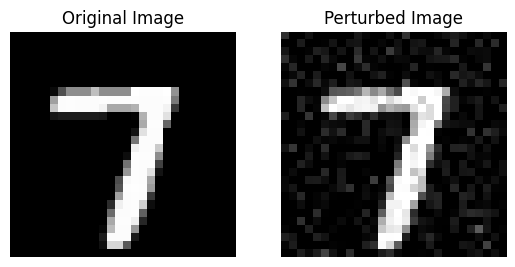

Image 3:
Distance to original: 3.6713554859161377
Success rate: 1
-------------------------------------


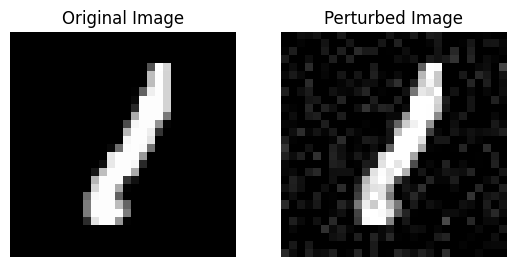

Image 4:
Distance to original: 4.119768142700195
Success rate: 1
-------------------------------------


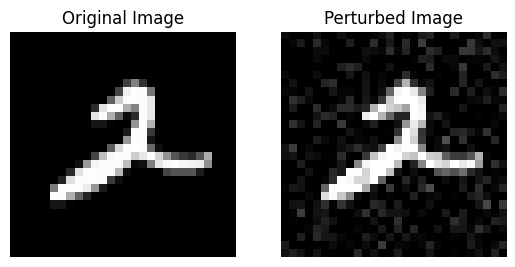

Image 5:
Distance to original: 4.1698198318481445
Success rate: 1
-------------------------------------


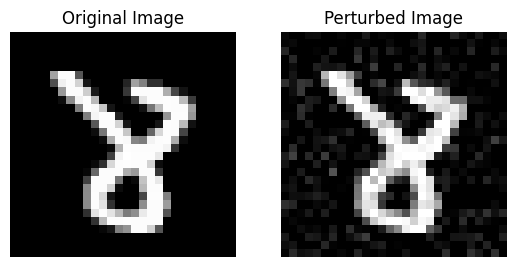

In [19]:
# Select five random images from the test set
num_images = 5
selected_indices = np.random.choice(len(testset), num_images, replace=False)
selected_images = [testset[i][0] for i in selected_indices]
selected_labels = [testset[i][1] for i in selected_indices]

# Perform the attacks and evaluate their performance
epsilon = 0.2
kernel_size = (5, 5)
sigma = 1.5

for i in range(num_images):
    original_image = selected_images[i].to(device)
    original_label = selected_labels[i]

    # Additive Noise Attack
    perturbed_image = additive_noise_attack(original_image, epsilon)
    perturbed_image = torch.clamp(perturbed_image, min=-1, max=1)
    perturbed_image = perturbed_image.unsqueeze(0).to(device)
    perturbed_output = model(perturbed_image)
    _, perturbed_prediction = torch.max(perturbed_output.data, 1)
    perturbed_success_rate = calculate_success_rate(perturbed_prediction, original_label)

    # Calculate the distance between the original and perturbed images
    distance = calculate_distance(original_image, perturbed_image)

    # Visualize the original and perturbed images
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(original_image.squeeze().cpu().numpy(), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(perturbed_image.squeeze().cpu().numpy(), cmap='gray')
    axes[1].set_title("Perturbed Image")
    axes[1].axis('off')

    # Display the results
    print(f"Image {i+1}:")
    print(f"Distance to original: {distance.item()}")
    print(f"Success rate: {perturbed_success_rate}")
    print("-------------------------------------")
    
    plt.show()

Image 1:
Distance to original: 16.447038650512695
Success rate: 1
-------------------------------------


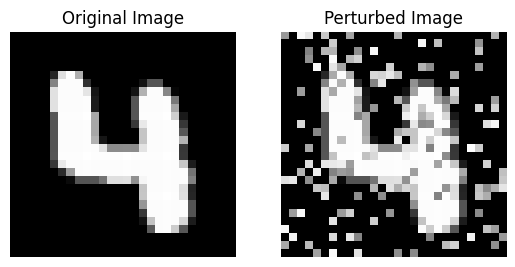

Image 2:
Distance to original: 17.893230438232422
Success rate: 1
-------------------------------------


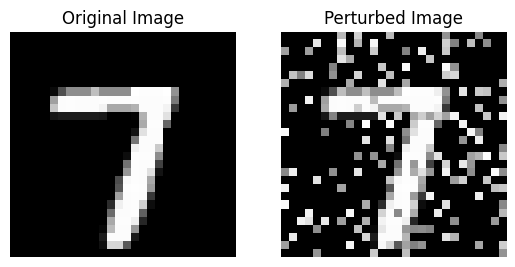

Image 3:
Distance to original: 18.712085723876953
Success rate: 1
-------------------------------------


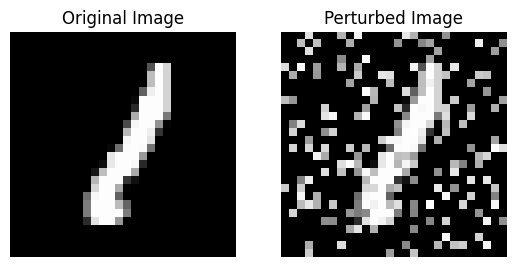

Image 4:
Distance to original: 18.04556655883789
Success rate: 1
-------------------------------------


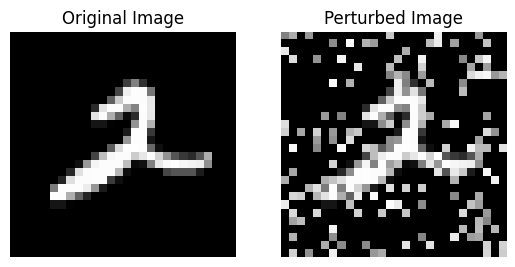

Image 5:
Distance to original: 16.145809173583984
Success rate: 1
-------------------------------------


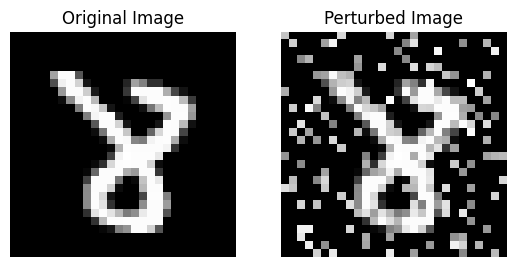

In [20]:
for i in range(num_images):
    original_image = selected_images[i].to(device)
    original_label = selected_labels[i]

    # Random Pixel Manipulation Attack
    perturbed_image = random_pixel_manipulation_attack(original_image, epsilon)
    perturbed_image = torch.clamp(perturbed_image, min=-1, max=1)
    perturbed_image = perturbed_image.unsqueeze(0).to(device)
    perturbed_output = model(perturbed_image)
    _, perturbed_prediction = torch.max(perturbed_output.data, 1)
    perturbed_success_rate = calculate_success_rate(perturbed_prediction, original_label)

    # Calculate the distance between the original and perturbed images
    distance = calculate_distance(original_image, perturbed_image)

    # Visualize the original and perturbed images
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(original_image.squeeze().cpu().numpy(), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(perturbed_image.squeeze().cpu().numpy(), cmap='gray')
    axes[1].set_title("Perturbed Image")
    axes[1].axis('off')

    # Display the results
    print(f"Image {i+1}:")
    print(f"Distance to original: {distance.item()}")
    print(f"Success rate: {perturbed_success_rate}")
    print("-------------------------------------")
    
    plt.show()

Image 1:
Distance to original: 7.140356063842773
Success rate: 1
-------------------------------------


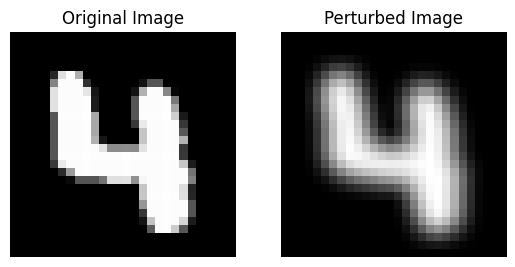

Image 2:
Distance to original: 7.376593112945557
Success rate: 1
-------------------------------------


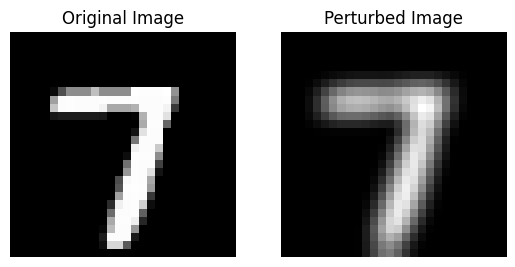

Image 3:
Distance to original: 6.14805793762207
Success rate: 1
-------------------------------------


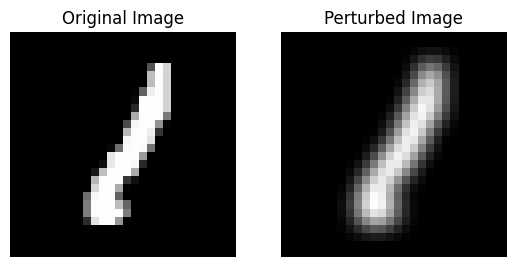

Image 4:
Distance to original: 7.609916687011719
Success rate: 1
-------------------------------------


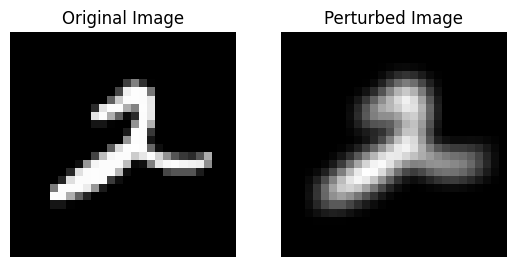

Image 5:
Distance to original: 8.878501892089844
Success rate: 1
-------------------------------------


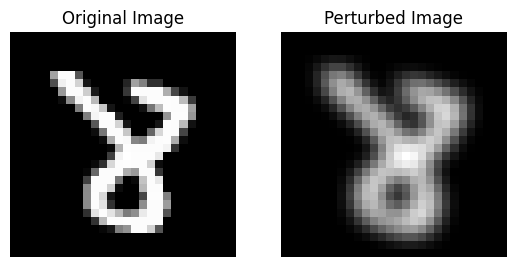

In [21]:
for i in range(num_images):
    original_image = selected_images[i].to(device)
    original_label = selected_labels[i]

    # Blurring Attack
    perturbed_image = blurring_attack(original_image, kernel_size, sigma)
    perturbed_image = perturbed_image.unsqueeze(0).to(device)
    perturbed_output = model(perturbed_image)
    _, perturbed_prediction = torch.max(perturbed_output.data, 1)
    perturbed_success_rate = calculate_success_rate(perturbed_prediction, original_label)

    # Calculate the distance between the original and perturbed images
    distance = calculate_distance(original_image, perturbed_image)

    # Visualize the original and perturbed images
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(original_image.squeeze().cpu().numpy(), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(perturbed_image.squeeze().cpu().numpy(), cmap='gray')
    axes[1].set_title("Perturbed Image")
    axes[1].axis('off')

    # Display the results
    print(f"Image {i+1}:")
    print(f"Distance to original: {distance.item()}")
    print(f"Success rate: {perturbed_success_rate}")
    print("-------------------------------------")
    
    plt.show()